In [23]:
import qml_essentials
from qml_essentials.coefficients import Coefficients
import jax, jax.numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from qml_essentials.ansaetze import Circuit
# from qml_essentials.ansaetze import PulseInformation as pinfo
from typing import Optional
import pickle

from models.controlled_rotations import *
from models.encodings import *


with open(f"../trained_models/controlled_models/trained_weights_standard_degree10_seed17", "rb") as f:
    all_trained_weights = pickle.load(f)

for w, n, d in all_trained_weights:
    if n == "basic_crz" and d == 211:
        weights = w

class MyHardwareEfficient(Circuit):
    @staticmethod
    def n_params_per_layer(n_qubits: int) -> int:
        return n_qubits * 2

    @staticmethod
    # def n_pulse_params_per_layer(n_qubits: int) -> int:
    #     n_params_RY = pinfo.num_params("RY")
    #     n_params_RZ = pinfo.num_params("RZ")
    #     n_params_CZ = pinfo.num_params("CZ")
    #
    #     n_pulse_params = (num_params_RY + num_params_RZ) * n_qubits
    #     n_pulse_params += num_params_CZ * (n_qubits - 1)
    #
    #     return pulse_params

    @staticmethod
    def get_control_indices(n_qubits: int) -> Optional[np.ndarray]:
        return None

    @staticmethod
    def build(weights: np.ndarray, n_qubits: int, **kwargs):
        w_idx = 0

        def W(theta):
            """
            train block
            RY with CRZ basic entangling layers
            """
            # idx = 0
            # RY to each qubit
            for i in range(n_qubits):
                qml.RZ(theta[i], wires=i)
                # idx += 1

            # Ring of CRZ
            for i in range(n_qubits):
                j = (i + 1) % n_qubits
                qml.CRX(theta[n_qubits + i], wires=[i, j])


        layer_size = 2 * n_qubits
        w_theta_size = 5 * layer_size
        trainblock_size = w_theta_size + n_qubits
        total_size = trainblock_size + w_theta_size + 1
        weights = jax.random.uniform(jax.random.PRNGKey(0), shape=(trainblock_size,), minval=0, maxval=0)

        w1 = weights[:w_theta_size].reshape(5, layer_size)
        w2 = weights[w_theta_size:trainblock_size]
        # w3 = weights[trainblock_size:-1].reshape(5, layer_size)

        for layer in range(5):
            W(w1[layer])

        # final RY to each qubit
        for i in range(n_qubits):
            qml.RZ(w2[i], wires=i)

        # for q in range(n_qubits):
        #     qml.RY(weights[w_idx], wires=q, **kwargs)
        #     w_idx += 1
        #     qml.RZ(weights[w_idx], wires=q, **kwargs)
        #     w_idx += 1
        #
        # if n_qubits > 1:
        #     for q in range(n_qubits - 1):
        #         qml.CZ(wires=[q, q + 1], **kwargs)

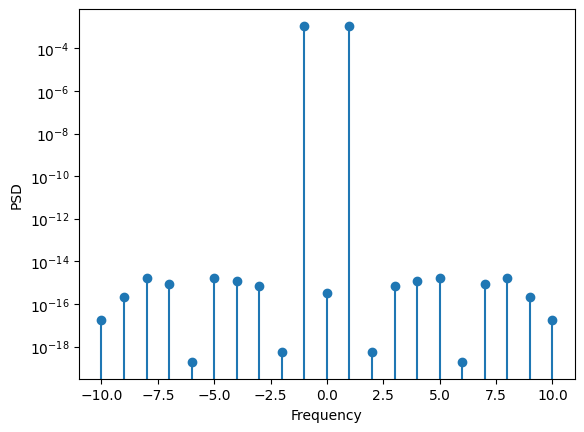

In [24]:
key = jax.random.PRNGKey(0)
from qml_essentials.model import Model

model = Model(
    n_qubits=10,
    n_layers=1,
    circuit_type=MyHardwareEfficient,
    output_qubit=0
)
coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1, shift=True)
psd = Coefficients.get_psd(coeffs)

fig, ax = plt.subplots()
ax.stem(freqs, psd)
ax.set_yscale("log")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.show()

(<Figure size 11600x1100 with 1 Axes>, <Axes: >)

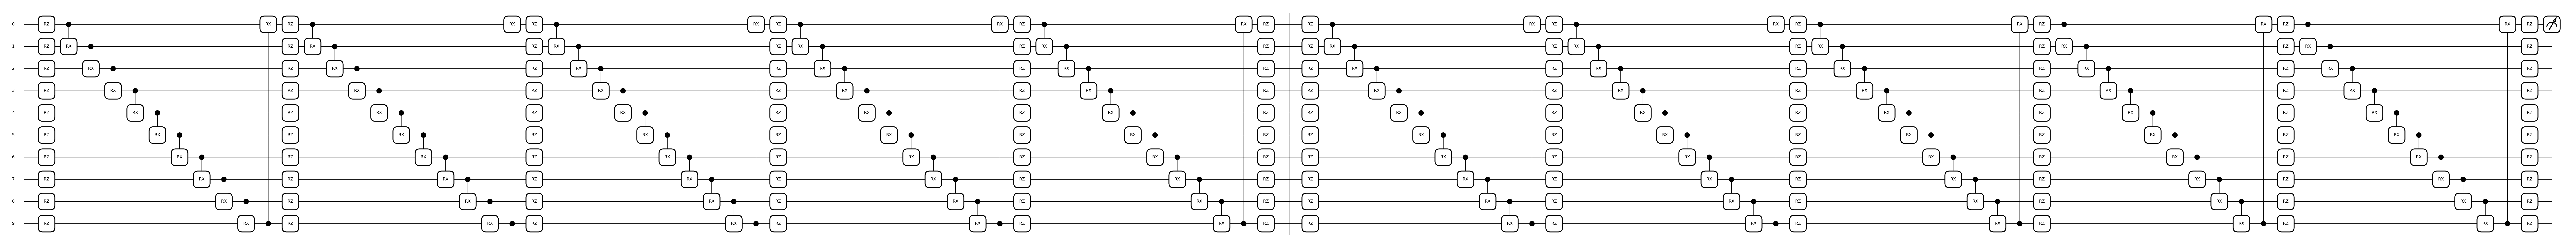

In [25]:
model.draw(figure="mpl")